One of the first things you learn to do in any experimental physics class is fit a line to data. We can do that pretty easily in python, but the tools we will use have some added flexibility (and therefore complexity).

The primary tool we will use is the `curve_fit` function from the `scipy` library.

In [1]:
import numpy as np
from scipy.optimize import curve_fit

In [2]:
help(curve_fit)

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : An M-length sequence or an (k,M)-shaped array for functions with k predictors
        The independent variable where the data is measured.
    ydata : M-length sequence
        The dependent data --- nominally f(xdata, ...)
    p0 : None, scalar, or N-length sequence, optional
        Initial guess for the parameters.  If None, then the initial
        values will all be 1 (if the number of parameters for the function
        can be det

You'll see that `curve_fit` doesn't just fit lines, but can fit any arbitrary function you can come up with. That's great, but it means you have a little work ahead of you to make the fit work.  Let's try something simple first: a linear fit to linear data.

In [3]:
slope = 4.0
intercept = 2.5
xdata = np.linspace(0,10,10)
ydata = intercept + slope*xdata

If we want to fit a linear function, we first have to write a generic linear function.

In [4]:
def linfunc(x, m, b):
    return m*x + b

Then it's as simple as calling `curve_fit`.

In [5]:
curve_fit(linfunc, xdata, ydata)

(array([ 4. ,  2.5]), array([[ 0., -0.],
        [-0.,  0.]]))

Two things are returned: the parameter values, and the covariance matrix (which roughly speakng is a measure of the uncertainty in those parameter values).  Here, of course, our data exactly fit our model, so the covariance was zero. Let's now add a little noise to make things interesting.

In [6]:
noise = np.random.normal(size=10)
curve_fit(linfunc, xdata, ydata+noise)

(array([ 3.89025614,  3.35165198]), array([[ 0.00845938, -0.0422969 ],
        [-0.0422969 ,  0.29764486]]))

At this point, it's hard to understand what's going on without plotting.  Let's do that.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

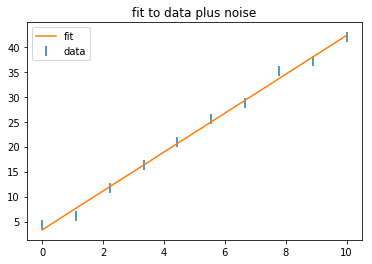

In [8]:
popt, pcov = curve_fit(linfunc, xdata, ydata+noise)
plt.errorbar(xdata, ydata+noise, yerr=1.0, linestyle="",label="data")
plt.plot(xdata, linfunc(xdata, *popt), label="fit")
plt.legend()
title = plt.title("fit to data plus noise")

In [9]:
print(popt)

[ 3.89025614  3.35165198]


In [10]:
print(slope, intercept)

4.0 2.5


### An exercise

Here are four datasets. produce a linear fit (and a plot like that above) for each. When you are done, make a table with the fitting parameters for each.  This collection of datasets is known as "Anscombe's quartet"

In [11]:
import pandas as pd

ans1 = pd.read_pickle("../data/ans1.pkl")
ans2 = pd.read_pickle("../data/ans2.pkl")
ans3 = pd.read_pickle("../data/ans3.pkl")
ans4 = pd.read_pickle("../data/ans4.pkl")

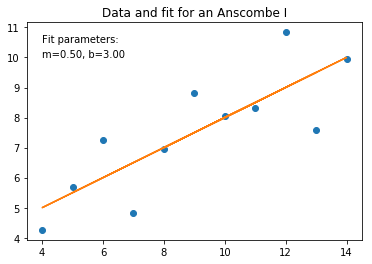

In [30]:
popt1, pcov1 = curve_fit(linfunc, ans1.x, ans1.y)
popt2, pcov2 = curve_fit(linfunc, ans2.x, ans2.y)
popt3, pcov3 = curve_fit(linfunc, ans3.x, ans3.y)
popt4, pcov4 = curve_fit(linfunc, ans4.x, ans4.y)

def anscombe_plot(ansdf, setlabel):
    popt, pcov = curve_fit(linfunc, ansdf.x, ansdf.y)
    plt.plot(ansdf.x, ansdf.y, "o", label="data")
    plt.plot(ansdf.x, linfunc(ansdf.x, *popt), label="fit")
    plt.text(4, 10, "m={:4.2f}, b={:4.2f}".format(popt[0], popt[1]))
    plt.text(4, 10.5, "Fit parameters:")
    title = plt.title("Data and fit for an Anscombe {}".format(setlabel))
    #plt.ylim(0,12)
anscombe_plot(ans1, "I")

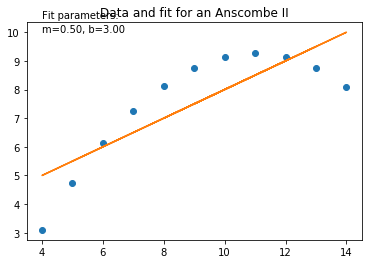

In [31]:
anscombe_plot(ans2, "II")

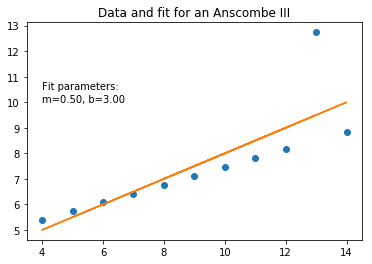

In [32]:
anscombe_plot(ans3, "III")

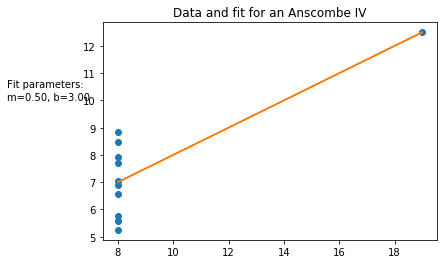

In [33]:
anscombe_plot(ans4, "IV")

### Measuring quality of fit

Simplest measure: the residual.

In [38]:
popt4, pcov4 = curve_fit(linfunc, ans4.x, ans4.y)
residual4 = ans4.y - linfunc(ans4.x, *popt4)
residual4

0    -4.210000e-01
1    -1.241000e+00
2     7.090000e-01
3     1.839000e+00
4     1.469000e+00
5     3.900000e-02
6    -1.751000e+00
7     1.636025e-11
8    -1.441000e+00
9     9.090000e-01
10   -1.110000e-01
dtype: float64

A vector is hard to deal with, though, so let's see if we can reduce this to a single number. There are a few useful approaches.